In [1]:
import gc
import time
import matplotlib.pyplot as plt

try:
    from lattice_field_mcmc import ScalarPhi4Model2D
except ModuleNotFoundError:
    !git clone https://github.com/ToelUl/Lattice-Field-MCMC-GPU.git
    !cp -r Lattice-Field-MCMC-GPU/lattice_field_mcmc ./
    from lattice_field_mcmc import ScalarPhi4Model2D

import torch
import numpy as np
from typing import Tuple, Optional

if not torch.cuda.is_available():
    print("⚠️ GPU runtime is not enabled. Please go to 'Runtime' > 'Change runtime type' and set 'Hardware accelerator' to 'GPU'.")
else:
    print("✅ GPU runtime is enabled and ready!")

/mnt/d/phd_research_projects/Lattice-Field-MCMC-GPU/lattice_field_mcmc/matter_fields/nearest_neighbor_coupling/samplers.py:254: SyntaxWarning: invalid escape sequence '\s'
  """Computes the total action S = \sum_x [ \kappa*K_x + V_x ]."""


✅ GPU runtime is enabled and ready!


In [2]:
L_size = 32
kappas = torch.linspace(0.22, 0.3, 64)
lambda_val = 0.02
chains = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

phi4_sampler = ScalarPhi4Model2D(
    L=L_size,
    kappa=kappas.to(device),
    lambda_=lambda_val,
    n_chains=chains,
    proposal_width=0.4,
    target_acceptance_rate=0.6,
    tune_interval=10,
    tuning_strength=0.2,
    device=device,
    use_amp=True,
    pt_enabled=True
)

start = time.time()
samples = phi4_sampler.forward(
    n_sweeps=3000,
    n_therm=3000,
    decorrelate=10,
    pt_interval=2
)
end = time.time()

print(f"Simulation complete. Sample tensor shape: {samples.shape}")
print(f"Elapsed time: {end - start:.2f} seconds")

Initialized ScalarLatticeSampler2D on device: cuda
 L=32, BatchSize=64, ChainsPerKappa=10, AMP=True, PT=True, LargeSim=False
Proposal width tuning enabled: target_rate=0.6, interval=10
Starting simulation: 3000 thermalization sweeps, 3000 production sweeps.
Proposal width tuning is ENABLED.
  [Tuning] Avg Acc Rate: 0.920 -> Avg Proposal Width: 0.426
  [Tuning] Avg Acc Rate: 0.922 -> Avg Proposal Width: 0.453
  [Tuning] Avg Acc Rate: 0.922 -> Avg Proposal Width: 0.482
  [Tuning] Avg Acc Rate: 0.922 -> Avg Proposal Width: 0.513
  [Tuning] Avg Acc Rate: 0.921 -> Avg Proposal Width: 0.546
  [Tuning] Avg Acc Rate: 0.918 -> Avg Proposal Width: 0.581
  [Tuning] Avg Acc Rate: 0.915 -> Avg Proposal Width: 0.618
  [Tuning] Avg Acc Rate: 0.911 -> Avg Proposal Width: 0.656
  [Tuning] Avg Acc Rate: 0.906 -> Avg Proposal Width: 0.696
  [Tuning] Avg Acc Rate: 0.901 -> Avg Proposal Width: 0.738
  [Tuning] Avg Acc Rate: 0.895 -> Avg Proposal Width: 0.782
  [Tuning] Avg Acc Rate: 0.889 -> Avg Proposal W


Calculating observables and plotting results...


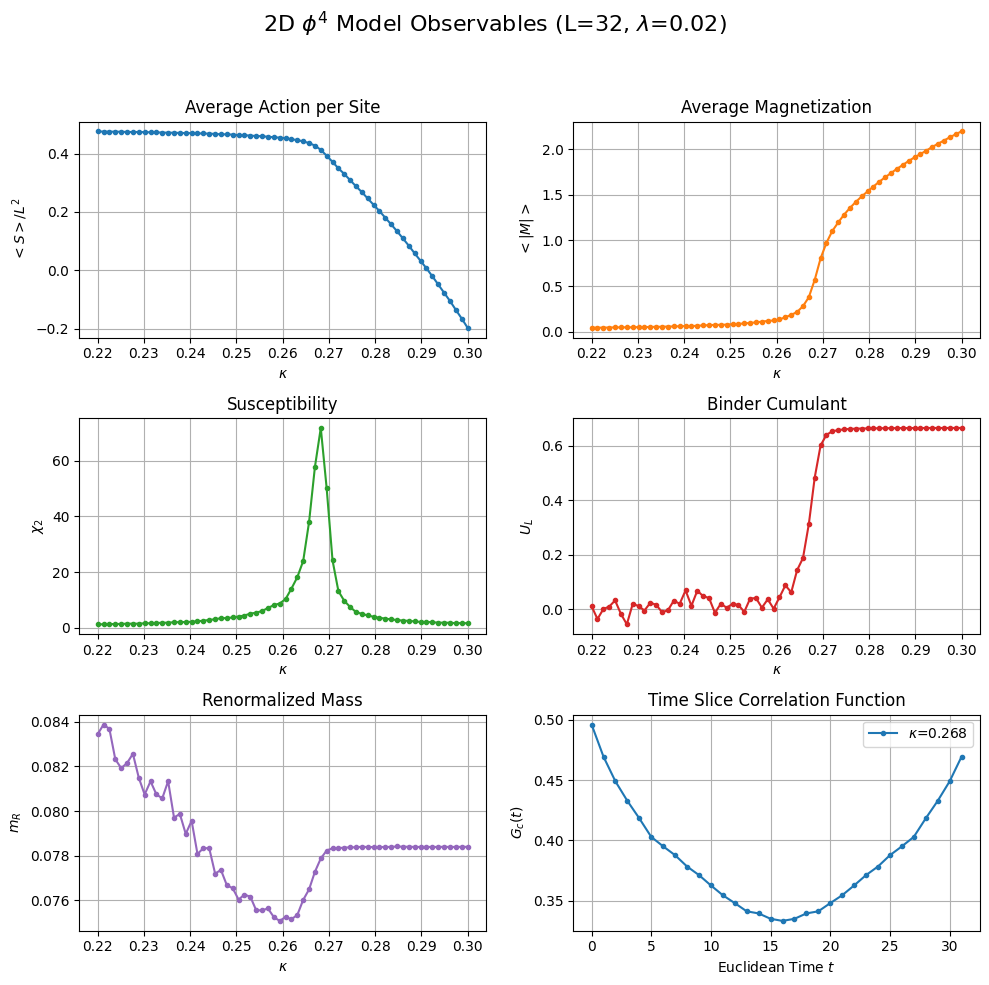

In [3]:
# =========================================================================
# Plotting Results
# =========================================================================
print("\nCalculating observables and plotting results...")

# Move samples and kappa to CPU for plotting
kappas_cpu = phi4_sampler.kappa.cpu().numpy()

# Calculate all observables
avg_action = phi4_sampler.compute_average_action(samples).cpu().numpy()
avg_mag = phi4_sampler.compute_average_magnetization(samples).cpu().numpy()
susceptibility = phi4_sampler.compute_susceptibility(samples).cpu().numpy()
binder = phi4_sampler.compute_binder_cumulant(samples).cpu().numpy()
renorm_mass = phi4_sampler.compute_renormalized_mass(samples).cpu().numpy()
rescaled_mass = phi4_sampler.compute_rescaled_renormalized_mass(samples).cpu().numpy()
time_corr = phi4_sampler.compute_time_slice_correlation(samples).cpu().numpy()

# Create a 4x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle(f'2D $\\phi^4$ Model Observables (L={L_size}, $\\lambda$={lambda_val})', fontsize=16)

# Plot 1: Average Action
axs[0, 0].plot(kappas_cpu, avg_action, 'o-', markersize=3)
axs[0, 0].set_title('Average Action per Site')
axs[0, 0].set_xlabel('$\\kappa$')
axs[0, 0].set_ylabel('$<S> / L^2$')
axs[0, 0].grid(True)

# Plot 2: Average Magnetization
axs[0, 1].plot(kappas_cpu, avg_mag, 'o-', markersize=3, color='tab:orange')
axs[0, 1].set_title('Average Magnetization')
axs[0, 1].set_xlabel('$\\kappa$')
axs[0, 1].set_ylabel('$<|M|>$')
axs[0, 1].grid(True)

# Plot 3: Susceptibility
axs[1, 0].plot(kappas_cpu, susceptibility, 'o-', markersize=3, color='tab:green')
axs[1, 0].set_title('Susceptibility')
axs[1, 0].set_xlabel('$\\kappa$')
axs[1, 0].set_ylabel('$\\chi_2$')
axs[1, 0].grid(True)

# Plot 4: Binder Cumulant
axs[1, 1].plot(kappas_cpu, binder, 'o-', markersize=3, color='tab:red')
axs[1, 1].set_title('Binder Cumulant')
axs[1, 1].set_xlabel('$\\kappa$')
axs[1, 1].set_ylabel('$U_L$')
axs[1, 1].grid(True)

# Plot 5: Renormalized Mass
axs[2, 0].plot(kappas_cpu, renorm_mass, 'o-', markersize=3, color='tab:purple')
axs[2, 0].set_title('Renormalized Mass')
axs[2, 0].set_xlabel('$\\kappa$')
axs[2, 0].set_ylabel('$m_R$')
axs[2, 0].grid(True)

# Plot 7: Time Slice Correlation
# Select a few representative kappa values to plot
num_kappas = len(kappas_cpu)
indices_to_plot = [
    # int(num_kappas * 0.1),  # Symmetric phase
    np.argmax(susceptibility), # Near critical point
    # int(num_kappas * 0.9)   # Broken phase
]

euclidean_time = np.arange(L_size)
for idx in indices_to_plot:
    kappa_val = kappas_cpu[idx]
    axs[2, 1].plot(
        euclidean_time,
        time_corr[idx],
        '.-',
        label=f'$\\kappa$={kappa_val:.3f}'
    )
axs[2, 1].set_title('Time Slice Correlation Function')
axs[2, 1].set_xlabel('Euclidean Time $t$')
axs[2, 1].set_ylabel('$G_c(t)$')
axs[2, 1].legend()
axs[2, 1].grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

In [4]:
del samples, phi4_sampler, kappas_cpu, avg_action, avg_mag, susceptibility, binder, renorm_mass, rescaled_mass, time_corr
gc.collect()
torch.cuda.empty_cache()

In [5]:
# =============================================================================
# Phase Diagram Generation and Plotting
# =============================================================================
def generate_phi4_phase_diagram(
    L: int = 16,
    kappa_range: Tuple[float, float] = (0.1, 0.5),
    lambda_range: Tuple[float, float] = (0.001, 0.015),
    n_kappa: int = 64,
    n_lambda: int = 20,
    n_chains: int = 10,
    n_sweeps: int = 3000,
    n_therm: int = 5000,
    decorrelate: int = 10,
    device: Optional[torch.device] = None
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates a 2D magnetization phase diagram by simulating the phi-4 model.

    This function utilizes the provided ScalarPhi4Model2D class to run Monte
    Carlo simulations over a grid of kappa and lambda parameters. It calculates
    the average magnetization for each point on the grid and returns a 2D array
    suitable for visualization.

    Args:
        L (int): The linear size of the lattice (L x L).
        kappa_range (Tuple[float, float]): The range of kappa values (min, max).
        lambda_range (Tuple[float, float]): The range of lambda values (min, max).
        n_kappa (int): The number of points to sample on the kappa axis.
        n_lambda (int): The number of points to sample on the lambda axis.
        n_chains (int): The number of independent Monte Carlo chains per kappa.
        n_sweeps (int): The number of production sweeps to perform after thermalization.
        n_therm (int): The number of thermalization sweeps to bring the system to equilibrium.
        decorrelate (int): The interval (in sweeps) at which to save a sample.
        device (Optional[torch.device]): The PyTorch device to use for computation.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple containing:
            - magnetization_map (np.ndarray): A 2D array of magnetization values.
            - kappa_vals (np.ndarray): The corresponding array of kappa values.
            - lambda_vals (np.ndarray): The corresponding array of lambda values.
    """
    # 1. Set up the parameter grid
    kappa_vals_torch = torch.linspace(kappa_range[0], kappa_range[1], n_kappa)
    lambda_vals = np.linspace(lambda_range[0], lambda_range[1], n_lambda)
    magnetization_map = np.zeros((n_lambda, n_kappa))

    # 2. Determine the computation device
    if device is None:
        sim_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        sim_device = device

    print(f"Starting phase diagram generation on device: {sim_device}")
    print(f"Grid size: {n_lambda} (lambda) x {n_kappa} (kappa)")

    # 3. Iterate over all lambda values
    for i, lam in enumerate(lambda_vals):
        print(f"\n--- Processing lambda = {lam:.4f} ({i+1}/{n_lambda}) ---")

        # 4. Instantiate the model for the current lambda and all kappas
        # This approach leverages the model's ability to handle a batch of
        # kappa values in parallel, which is more efficient.
        model = ScalarPhi4Model2D(
            L=L,
            kappa=kappa_vals_torch,
            lambda_=lam,
            n_chains=n_chains,
            proposal_width=0.4,
            target_acceptance_rate=0.6,
            tune_interval=10,
            tuning_strength=0.2,
            device=sim_device,
            use_amp=(sim_device.type == 'cuda'),
            pt_enabled=True
        )

        # 5. Run the simulation
        samples = model.forward(
            n_sweeps=n_sweeps,
            n_therm=n_therm,
            decorrelate=decorrelate
        )  # Returns shape: [n_kappa, n_total_samples, L, L]

        # 6. Compute and store the average magnetization
        # This method computes |<M>| for each kappa.
        avg_mag = model.compute_average_magnetization(field=samples) # Returns shape: [n_kappa]

        # 7. Store the results in our 2D map
        magnetization_map[i, :] = avg_mag.cpu().numpy()

        # 8. Clean up memory for the next iteration
        del model, samples, avg_mag
        gc.collect()
        if sim_device.type == 'cuda':
            torch.cuda.empty_cache()

    print("\nPhase diagram generation complete.")
    return magnetization_map, kappa_vals_torch.numpy(), lambda_vals

def plot_phase_diagram(
    magnetization_map: np.ndarray,
    kappa_vals: np.ndarray,
    lambda_vals: np.ndarray,
    L: int
) -> None:
    """
    Visualizes the magnetization phase diagram.

    Args:
        magnetization_map (np.ndarray): A 2D array of magnetization values.
        kappa_vals (np.ndarray): The kappa values for the x-axis.
        lambda_vals (np.ndarray): The lambda values for the y-axis.
        L (int): The lattice size, used for the plot title.
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Use pcolormesh for color rendering with Gouraud shading for smooth transitions
    im = ax.pcolormesh(
        kappa_vals,
        lambda_vals,
        magnetization_map,
        shading='gouraud',
        cmap='inferno' # You can choose other colormaps like 'plasma', 'viridis', 'magma'
    )

    # Add a colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Average Magnetization |<M>|', fontsize=12)

    # Set titles and labels
    ax.set_title(f'Phi-4 Model Magnetization Phase Diagram (L={L})', fontsize=16)
    ax.set_xlabel('kappa ($\\kappa$)', fontsize=14)
    ax.set_ylabel('lambda ($\\lambda$)', fontsize=14)

    # Adjust tick label size
    ax.tick_params(axis='both', which='major', labelsize=10)

    plt.show()

In [6]:
# --- Simulation Parameters ---
# Using smaller parameters here for a quick result.
# For a more accurate phase diagram, it is recommended to increase
# L, n_kappa, n_lambda, n_chains, and n_sweeps.
L_PARAM = 16          # Lattice size
KAPPA_POINTS = 64     # Resolution on the Kappa axis
LAMBDA_POINTS = 20    # Resolution on the Lambda axis
CHAINS = 10           # Number of independent chains per parameter point
SWEEPS = 3000         # Number of production sweeps
THERM_SWEEPS = 1500   # Number of thermalization sweeps
DECORRELATE_STEP = 10 # Decorrelation step for samples

# Run the simulation to generate the data
mag_map, kappas, lambdas = generate_phi4_phase_diagram(
    L=L_PARAM,
    n_kappa=KAPPA_POINTS,
    n_lambda=LAMBDA_POINTS,
    n_chains=CHAINS,
    n_sweeps=SWEEPS,
    n_therm=THERM_SWEEPS,
    decorrelate=DECORRELATE_STEP
)

Starting phase diagram generation on device: cuda
Grid size: 20 (lambda) x 64 (kappa)

--- Processing lambda = 0.0010 (1/20) ---
Initialized ScalarLatticeSampler2D on device: cuda
 L=16, BatchSize=64, ChainsPerKappa=10, AMP=True, PT=True, LargeSim=False
Proposal width tuning enabled: target_rate=0.6, interval=10
Starting simulation: 1500 thermalization sweeps, 3000 production sweeps.
Proposal width tuning is ENABLED.
  [Tuning] Avg Acc Rate: 0.919 -> Avg Proposal Width: 0.426
  [Tuning] Avg Acc Rate: 0.921 -> Avg Proposal Width: 0.453
  [Tuning] Avg Acc Rate: 0.921 -> Avg Proposal Width: 0.482
  [Tuning] Avg Acc Rate: 0.921 -> Avg Proposal Width: 0.513
  [Tuning] Avg Acc Rate: 0.919 -> Avg Proposal Width: 0.546
  [Tuning] Avg Acc Rate: 0.916 -> Avg Proposal Width: 0.580
  [Tuning] Avg Acc Rate: 0.912 -> Avg Proposal Width: 0.616
  [Tuning] Avg Acc Rate: 0.907 -> Avg Proposal Width: 0.654
  [Tuning] Avg Acc Rate: 0.901 -> Avg Proposal Width: 0.694
  [Tuning] Avg Acc Rate: 0.894 -> Avg P

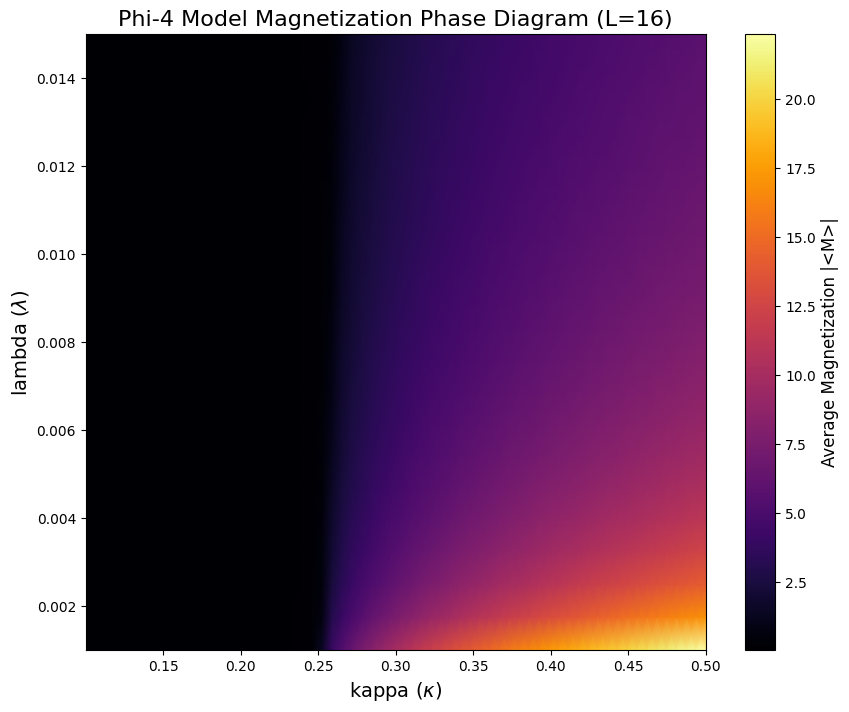

In [7]:
# Plot the results
plot_phase_diagram(mag_map, kappas, lambdas, L=L_PARAM)